# Basic NLP Analysis

In [50]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import spacy  # +run: python -m spacy download en_core_web_sm
import nltk
import string
from scipy.stats import mannwhitneyu
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

nlp = spacy.load("en_core_web_sm")

try:
    import cPickle as pickle
except ImportError:
    import pickle
import re

from tqdm.notebook import tqdm

tqdm.pandas()  # for using tqdm with pandas.apply()

color = sns.color_palette()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nutzer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Nutzer\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nutzer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [51]:
# reload sub-modules on change
# UsageError: Line magic function `%` not found. -> make sure it's '%load_ext autoreload' and not '% load_ext autoreload' (with space)
%load_ext autoreload
%autoreload 2

def reset_layout():
    sns.set(rc={'figure.figsize': (30, 8)})
    sns.set(font_scale=1.8)  # 1.8

reset_layout()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read+preprocess the data

In [52]:
punctuation = string.punctuation + "•’➖"

# get list of emojis
with open('resources/Emoji_Dict.p', 'rb') as fp:
    emoji_dict = pickle.load(fp)
emojis = list(emoji_dict.values())
tmp = " ".join(emojis)
# problem: some emojis are put together in groups (e.g. 🥉 🆎). We just want the unique emojis, e.g. 🥉 and 🆎
emojis_str = "".join(set(tmp.split(" ")))
# result: all unique emojis

In [53]:
def split_by_trailing_hashtags(text, punctuation_string=""):
    """
    Splits text into two parts:
    head: text including hashtags in the text
    tail: all trailing hashtags
    :param text:
    :param punctuation_string: characters in this string will be ignored when splitting
    e.g. "text .#bla #blub" will be split into "text" ".#bla #blub" (note the 'lost' space in the middle, have to add that when merging back)
    :return:
    """
    tail = []

    arr = text.split(" ")
    while len(arr) > 0:
        if arr[-1].startswith("#") or arr[-1].startswith("@") or arr[-1] in punctuation_string:
            tail = [arr[-1]] + tail
            arr = arr[:-1]
        else:
            break
    head = " ".join(arr)
    tail = " ".join(tail)

    return head, tail

def remove_hashtags(text):
    return re.sub(r"#(\w+)", "", text)

def remove_mentions(text):
    return re.sub(r"@(\w+)", "", text)

def remove_emojis(text):
    # replace emojis with spaces (not with "" to avoid situations like love🖤hamburg-> lovehamburg)
    text_sub = re.sub("["+emojis_str+"]"," ", text)
    # remove multiple spaces
    return re.sub(' +', " ", text_sub)

In [54]:
from util import file_manager
df_all = file_manager.get_posts()
df_all["caption_en_unsocialmedia"] = df_all["caption_en"].apply(remove_hashtags).apply(remove_mentions).progress_apply(remove_emojis)
# filter out posts by the same person on the same day with the same caption
df_all["date"] = df_all.index.date
df_all = df_all.drop_duplicates(subset=["owner_id", "date", "caption"])
def truncate_project(name): return name.split("(")[0].strip()
df_all["project_trunc"] = df_all["project"].apply(truncate_project)

  0%|          | 0/419014 [00:00<?, ?it/s]

## Read the rest of the data

In [55]:
df_projects = file_manager.get_projects()
projects = list(df_projects["Handle"])
class_preds = file_manager.get_image_labels()
df_projects[["Dataset", "Handle"]]

# read datasets
data = {}
for idx, row in tqdm(df_projects.iterrows(), total=len(df_projects)):
    dataset, project, architect = row["Dataset"], row["Handle"], row["Firm name"]
    df = df_all[df_all["project"] == project]
    df.name = project
    data[project] = {}
    data[project]["df"] = df
    data[project]["opening"] = row["Opening"]
    data[project]["completion"] = row["Completion"]
    data[project]["architect"] = architect

  0%|          | 0/16 [00:00<?, ?it/s]

In [56]:
result_path = "output/NLP"
os.makedirs(result_path, exist_ok=True)

## Mentions of the Architect
### How often does the architect get mentioned in hashtags, does that change over time?

get hashtags the architect get mentioned by frequenly (taken from the list of hashtags sorted by occurence)

In [57]:
architect_hashtag_lookup = {
    "Centro Niemeyer (Avilés)": ["#niemeyer", "#oscarniemeyer"],
    "Elbphilharmonie (Hamburg)": ["#herzogdemeuron", "#herzoganddemeuron"],
    "Hepworth (Wakefield)": ["#davidchipperfield", "#davidchipperfieldarchitects", "#chipperfield"],
    "ICE Krakow (Krakow)": ["#arataisozaki", "#isozaki"],
    "Louvre Lens (Lens)": ["#sanaa", "#sanaaarchitects"],
    "Markthal (Rotterdam)": ["#mvrdv", "#mvrdvarchitects"],
    "Matmut Atlantique (Bordeaux)": ["#herzogdemeuron", "#herzoganddemeuron"],
    "Messeplatz (Basel)": ["#herzogdemeuron", "#herzoganddemeuron"],
    "MUDEC (Milan)": ["#davidchipperfield", "#davidchipperfieldarchitects", "#chipperfield"],
    "MUSE (Trento)": ["#renzopiano", "#renzopianobuildingworkshop"],
    "Musée des Confluences (Lyon)": ["#coophimmelblau", "#coophimmelbau", "#himmelblau"],
    "Musikkens Hus (Aalborg)": ["#coophimmelblau", "#coophimmelbau", "#himmelblau"],
    "Ragnarock (Roskilde)": ["#mvrdv", "#mvrdvarchitects"],
    "Riverside Museum (Glasgow)": ["#zahahadid", "#zahahadidarchitects"],
    "SSE Hydro (Glasgow)": ["#normanfoster", "#fosterandpartners"],
    "Turner Contemporary (Margate)": ["#davidchipperfield", "#davidchipperfieldarchitects", "#chipperfield"]
}

,project,architect,hashtag freq
0,Centro Niemeyer (Avilés),Oscar Niemeyer,0.299361
1,Elbphilharmonie (Hamburg),Herzog & de Meuron,0.025079
2,Hepworth (Wakefield),David Chipperfield,0.029259
3,ICE Krakow (Krakow),Isozaki,0.001564
4,Louvre Lens (Lens),SANAA Architects,0.077671
5,Markthal (Rotterdam),MVRDV,0.032202
6,Matmut Atlantique (Bordeaux),Herzog & de Meuron,0.018280
7,Messeplatz (Basel),Herzog & de Meuron,0.135756
8,MUDEC (Milan),David Chipperfield,0.030118
9,MUSE (Trento),Renzo Piano,0.116615


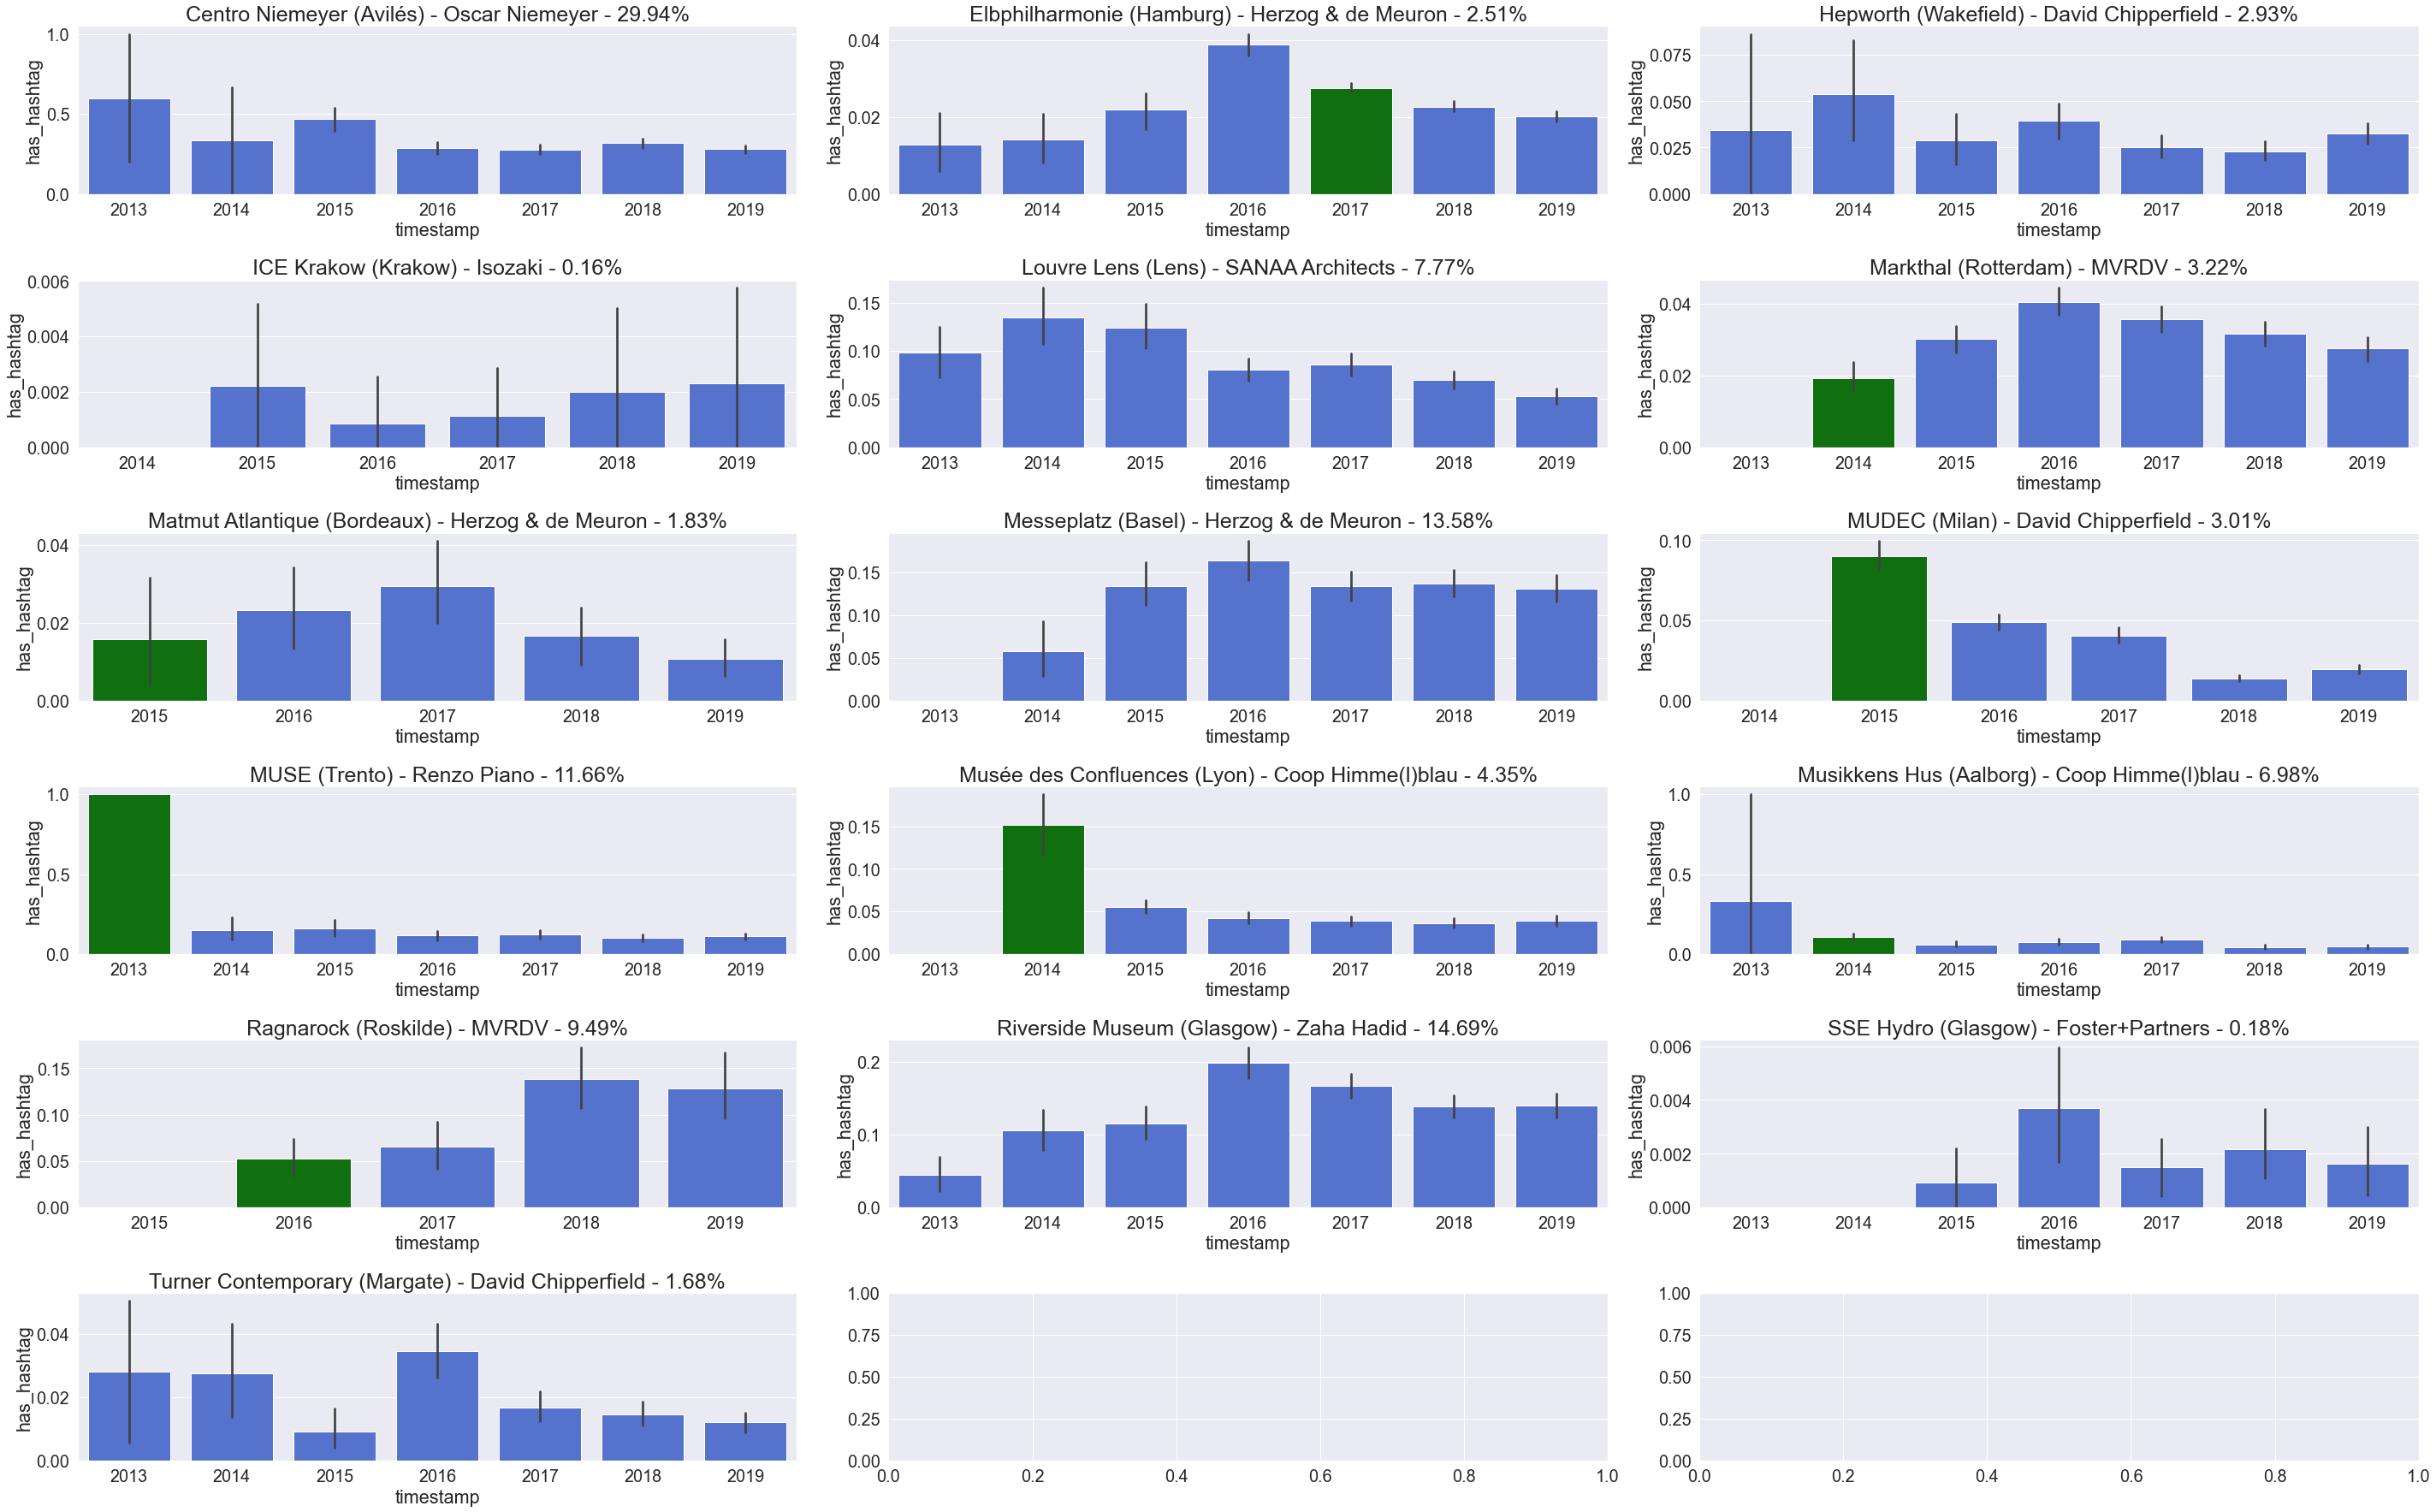

In [58]:
def get_hashtag_presence(ser, hashtags):
    if isinstance(hashtags, str):
        return ser["hashtags"].apply(lambda x: hashtags in x)
    else:
        return ser.apply(lambda x: any(hashtag in x for hashtag in hashtags))


collector = []

n_cols = 3
fig, axs = plt.subplots(6, n_cols, figsize=[40, 25])
for i, project in enumerate(data):
    res = data[project]
    df = res["df"]
    opening_year = pd.to_datetime(res["opening"]).year

    # create new dataframe whether the hashtag is present or not
    architect_hashtags = architect_hashtag_lookup[project]
    has_hashtag = get_hashtag_presence(df["hashtags"], architect_hashtags)
    tmp = has_hashtag.rename("has_hashtag").to_frame()
    tmp["no_hashtag"] = ~tmp["has_hashtag"]
    tmp["total"] = 1

    # add result to df
    df["has_architect_hashtag"] = list(has_hashtag.astype(int))

    # limting the observation range to 2013+ since sample size is very small before that
    tmp = tmp[tmp.index.year >= 2013]

    # group by year and calculate realtive frequency of whether the hashtag is present
    freq_group = tmp.groupby(tmp.index.year)[["has_hashtag", "no_hashtag", "total"]].sum()
    freq_group["frequency"] = freq_group["has_hashtag"] / freq_group["total"]
    # freq_group.index = [str(x) for x in freq_group.index]
    total = freq_group["has_hashtag"].sum() / freq_group["total"].sum()
    # pl.stacked_barchart(freq_group[["has_hashtag", "no_hashtag"]])

    # plot hashtag frequency over time
    ax = axs[int(i / n_cols), i % n_cols]
    palette = {year: "royalblue" for year in np.unique(tmp.index.year)}
    palette[opening_year] = "green"
    sns.barplot(x=tmp.index.year, y=tmp["has_hashtag"], palette=palette, ax=ax)
    ax.set_title("{} - {} - {:.2%}".format(project, res["architect"], total), fontsize=25)
    # print("{},{:.5f}".format(project ,total))
    # ax.axvline(x=2015, color='green',linewidth=3) # label='Opening: {}'.format(res["opening"])

    # collect hashtag frequency in table for all projects
    collector.append({"project": project, "architect": res["architect"], "hashtag freq": total})

plt.tight_layout()

# update df_all with the results
df_all = pd.concat([res["df"] for res in data.values()])

architect_frequency = pd.DataFrame(collector)
architect_frequency

note: Oscar Niemeyer is an outlier cause the architect is in the name of the project (Centro Niemeyer)

Text(0.5, 1.0, 'Hashtag Frequency by Architect')

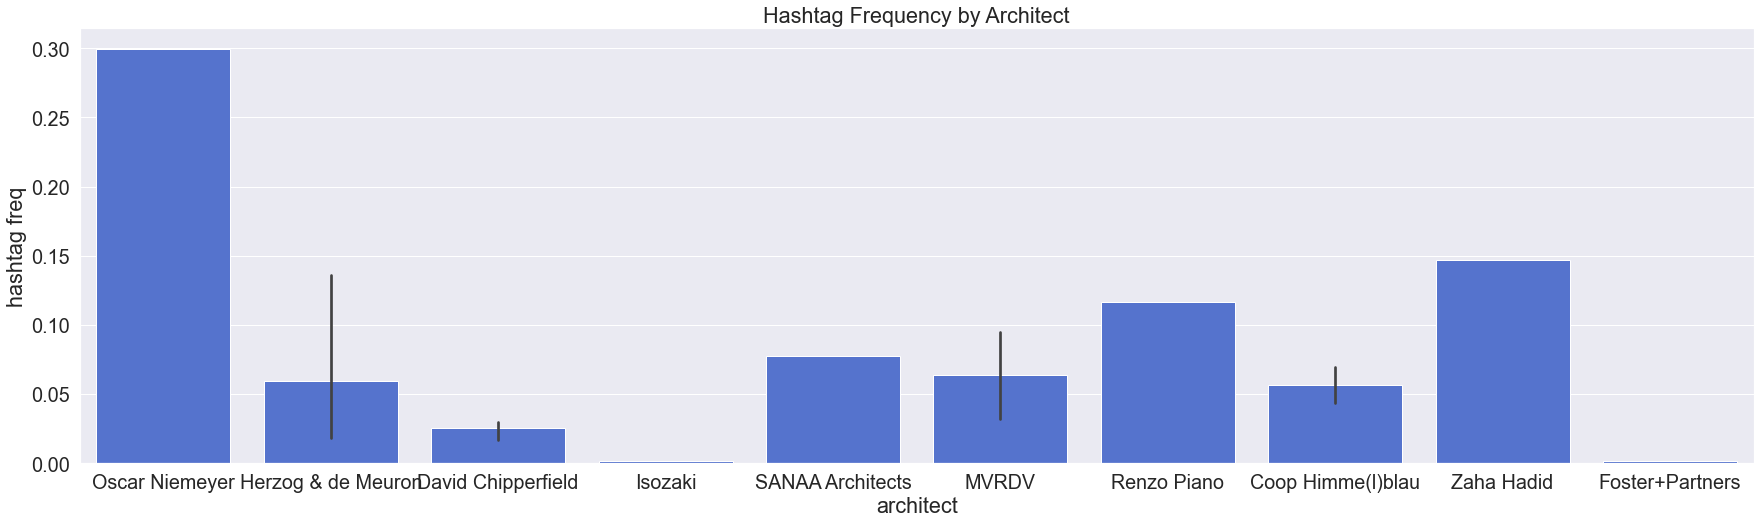

In [59]:
sns.barplot(data=architect_frequency, x="architect", y="hashtag freq", color="royalblue")
plt.title("Hashtag Frequency by Architect")

**Results**
- rise-then-fall trend for frequency over the years
- large differences in architect occurrence between projects, reason unclear

## Architecture vs. Progamme differences
### Do images of the architecture or programme generate more likes/comments?

In [61]:
old_index = df_all.index
df_all_class = df_all.merge(class_preds[["image", "class_pred"]], on="image", how="left")
df_all_class.index = old_index

In [62]:
df_all_class[["caption_en", "image", "class_pred"]].to_csv("posts_classes.csv", index=True)
df_all_class["project_trunc"] = df_all_class["project"].apply(truncate_project)

In [63]:
classes = ["Programme", "Architecture", "Food", "People", "Unrelated"]

In [64]:
def plot_class_stats(df, metric, mode="mean", alternative="less", plot_log=False, class1="Programme", class2="Architecture"):
    """
    df should have colums: class_pred, [metric]
    metric: likes / comments etc.
    plot_mode: mean or median
    """
    # plot it
    plt.figure()
    slice = df.copy()
    if plot_log:
        slice[metric] = slice[metric].apply(np.log1p)
    sns.violinplot(data=slice,x="project_trunc", y=metric, hue="class_pred", hue_order=[class1, class2], split=True, saturation=1)
    plt.title("{} by Image Class".format(metric.capitalize()), fontsize=60)
    plt.xlabel(None)
    plt.ylabel("{} (log)".format(metric))
    plt.xticks(rotation=90)
    plt.legend(loc=(0,0.815))

    # calculate mean and median across all observations of a project, then calculate mean across projects
    agg_mean = df.groupby(["project", "class_pred"])[metric].mean().reset_index()
    piv_mean = agg_mean.pivot(index="project", columns="class_pred", values=metric)
    print("mean: {:.2%}".format((piv_mean[class2] / piv_mean[class1]).mean()))

    agg_med = df.groupby(["project", "class_pred"])[metric].median().reset_index()
    piv_med = agg_med.pivot(index="project", columns="class_pred", values=metric)
    print("median: {:.2%}".format((piv_med[class2] / piv_med[class1]).mean()))


    # Statistical testing
    results = []
    for project in projects:
        slice = df[df["project"] == project]
        sample1 = slice[slice["class_pred"] == class1][metric]
        sample2 = slice[slice["class_pred"] == class2][metric]
        statistic, p_value = mannwhitneyu(sample1, sample2, alternative=alternative)
        if mode == "mean":
            results.append([sample1.mean(), sample2.mean(), p_value])
        else:
            results.append([sample1.median(), sample2.median(), p_value])
    return pd.DataFrame(data=results, index=projects, columns=["{} Prog".format(mode), "{} Arch".format(mode), "P-val ({})".format(alternative)])

median cause outliers -> numbers better represenent M-W-Utest results since it's rank-based

mean: 138.46%
median: 123.14%


,median Prog,median Arch,P-val (greater)
Centro Niemeyer (Avilés),33.0,41.0,1.000000e+00
Elbphilharmonie (Hamburg),33.0,31.0,1.877197e-02
Hepworth (Wakefield),34.0,27.0,2.917947e-09
ICE Krakow (Krakow),37.0,56.0,1.000000e+00
Louvre Lens (Lens),21.0,30.0,1.000000e+00
Markthal (Rotterdam),25.0,25.0,4.737329e-01
Matmut Atlantique (Bordeaux),29.0,32.0,9.969558e-01
Messeplatz (Basel),31.0,39.0,1.000000e+00
MUDEC (Milan),26.0,27.0,9.985264e-01
MUSE (Trento),29.0,37.0,1.000000e+00


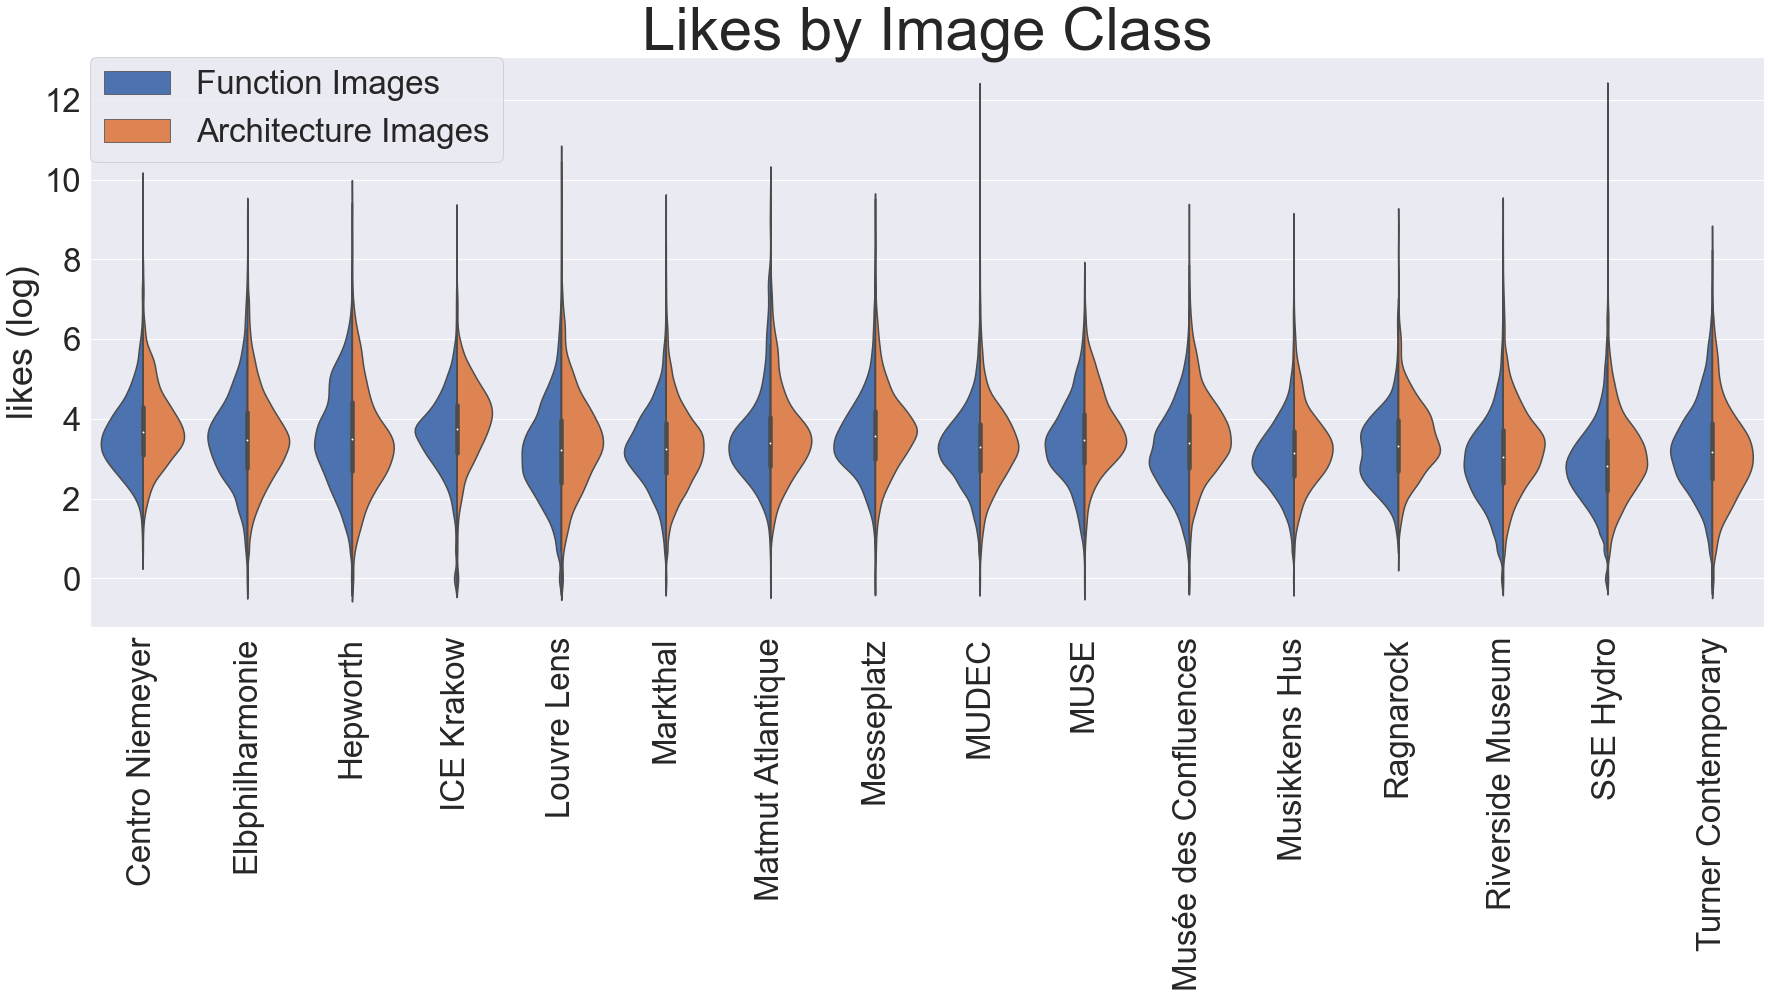

In [65]:
# sns.set(rc={'figure.figsize': (17, 6)})

sns.set(rc={'figure.figsize': (30, 10.5)})
sns.set(font_scale=3)

slice = df_all_class[df_all_class["class_pred"].isin(["Programme", "Architecture"])]
slice = slice[slice["likes"] != -1] # filter out posts where likes are hidden
slice["class_pred"] = slice["class_pred"].replace("Programme", "Function Images")
slice["class_pred"] = slice["class_pred"].replace("Architecture", "Architecture Images")

plot_class_stats(slice, metric="likes", mode="median", plot_log=True, alternative="greater", class1="Function Images", class2="Architecture Images")

median for comments is nonsensical cause the values are super low (0,1,2) -> so we use mean

mean: 131.27%
median: inf%


,mean Prog,mean Arch,P-val (greater)
Centro Niemeyer (Avilés),2.335591,3.423534,1.000000
Elbphilharmonie (Hamburg),2.328767,2.583914,0.579661
Hepworth (Wakefield),1.759865,1.678409,0.012773
ICE Krakow (Krakow),1.410652,2.270257,1.000000
Louvre Lens (Lens),1.675369,2.908789,1.000000
Markthal (Rotterdam),2.383954,2.180982,0.180898
Matmut Atlantique (Bordeaux),2.203829,3.647122,0.641226
Messeplatz (Basel),1.578869,2.703260,1.000000
MUDEC (Milan),1.190992,1.599588,0.108980
MUSE (Trento),1.700046,1.779725,0.957374


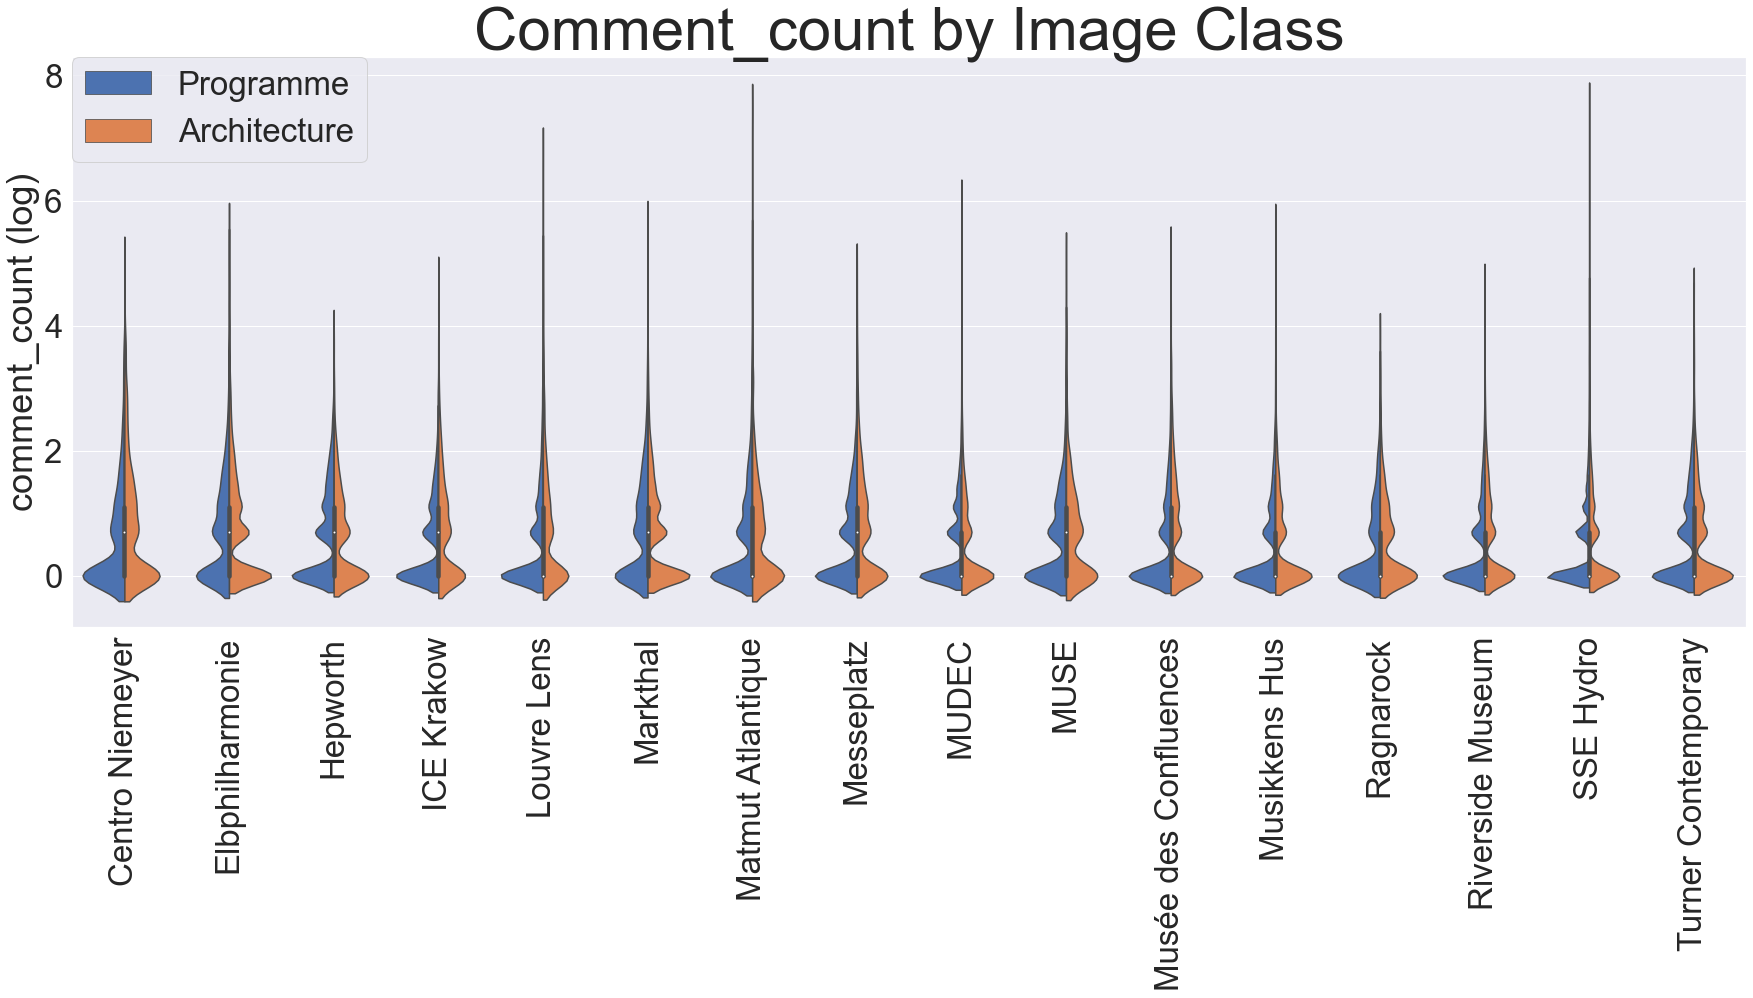

In [66]:
slice = df_all_class[df_all_class["class_pred"].isin(["Programme", "Architecture"])]
slice = slice[slice["comment_count"] != -1]
plot_class_stats(slice, metric="comment_count", mode="mean", plot_log=True, alternative="greater")

**Results**
Pictures of the architecture (compared to the programme):
- receive 38% (mean), 23% (median) more likes (mean/median over the likes then mean over the projects) -> median cause likes tend to have outliers / stretch multiple orders of magnitude
 For completeness: 'Architecture' pics also receive ~5% more total hashtags on average
- receive 30% (median) more comments (same as above)
- receive 17x more mentions of the architect in hashtags (kinda duh but nice to confirm our intuition)
- (comparing to AIP ratio): no correlation between percentage of architecture pictures and the number of likes on architecture vs. programme picture
 -> i.e. popularity in terms of post frequency and in terms of likes don't necessarily correlate

**Question:** what does that tell us w.r.t the 'cultural facility vs. photo-op' research question?
- To Instagram users, the architecture is more like/comment-able than the programme
- the architecture is deeply connected to the architect, much more than the programme


## Adjective, Verb Analysis
### Q: How do people perceive the projects (adjectives) how do people experience them (verbs) - agument results from topic modeling since it's only baaed on nouns

### Preprocessing: remove punctuation, stopwords and apply part-of-speech (POS) tagging
This takes a long time unfortunately

In [68]:
def remove_punct(doc):
    # generators enable faster processing in subsequent steps, just note that the generator will be empty after consumption
    return (t for t in doc if t.text not in punctuation)

def remove_stop_words(doc):
    return (t for t in doc if not t.is_stop)

def preprocess_text(doc):
    removed_punct = remove_punct(doc)
    removed_stop_words = remove_stop_words(removed_punct)
    return removed_stop_words

def spacy_pos_tag(doc):
    # doc: spacy nlp() object
    return [(token.text, token.pos_) for token in doc]

In [79]:
# take texts with hashtags and mentions removed
texts = df_all["caption_en_unsocialmedia"]
# use pipes for faster precessing
# the POS tagging needs lemmatization to work properly. Shame, cause it massively slows down the pipeline execution
# wrap output in List before turning into series because apparently the series constructor doesn't like generators
df_all["docs"] = list(tqdm(nlp.pipe(texts), total=len(texts))) # disable=["tok2vec", "ner", "parser", "lemmatizer"]
docs_clean = df_all["docs"].apply(preprocess_text)
df_all["caption_en_pos"] = list(docs_clean.apply(spacy_pos_tag)) # wrap in list to get rid of the index, which consuses pandas

# create a row for each word
d = []
for idx, row in tqdm(df_all.iterrows(), total=len(df_all)):
    timestamp, project, pos = idx, row["project"], row["caption_en_pos"]
    for word, tag in pos:
        d.append({"timestamp": timestamp, "project":project, "word": word.lower(), "pos_tag": tag})
df_pos = pd.DataFrame(d)
df_pos["word"].replace(pd.NA, "", inplace=True)

  0%|          | 0/401393 [00:00<?, ?it/s]

  0%|          | 0/401393 [00:00<?, ?it/s]

### Analyze frequency of words for POS tags (adjective, verb, noun)

In [80]:
def get_top_pos(words, pos_tags, target_pos):
    """
    Finds all words in a POS-tagged corpus that match the target POS
    :param pos_corpus: list of list of  ("word, [POS TAG]) tuples
    :param target_pos: https://universaldependencies.org/u/pos/
    :return: list of words that match the POS
    """
    return [word.lower() for word, tag in zip(words, pos_tags) if tag == target_pos]

def get_pos_count_df(df, group_column, target_pos, text_column="word", pos_column="pos_tag"):
    """
    Applies get_top_pos() to a dataframe and returns the result in a dataframe
    :param df: dataframe
    :param group_column: column name with different groups by which the results are split by
    :param target_pos: https://universaldependencies.org/u/pos/
    :param text_column: column with words
    :param pos_column: column with POS tag for each word
    :return: dataframe with top 20 most common words that match the POS per group
    """
    df_pos = pd.DataFrame()
    for tag in df[group_column].unique():
        slice = df[df[group_column] == tag]
        words = get_top_pos(slice[text_column], slice[pos_column], target_pos=target_pos)

        ser = pd.Series(words).value_counts().reset_index()
        ser.columns = [tag, tag + "_count"]

        df_pos = pd.concat([df_pos, ser[:20]], axis=1)
    return df_pos


def get_adjnouns(docs, target_pos="ADJ"):
    """
    Gets all ADJ-NOUN pairs in a corpus (docs) by parsing the dependency tree
    :param docs: list of spacy nlp() objects
    """
    collected = []
    for doc in docs:
        for token in doc:
            pos = token.pos_
            if pos == target_pos:
                head = token
                for i in range(len(doc)):  # avoid infinite cycles due to circiular dependenceis
                    head = head.head
                    if (str(head.dep_) == str(head.text)) or str(head.pos_) == "NOUN":
                        break
                if str(head.pos_) == "NOUN":
                    collected.append("{} {}".format(token.text.lower(), head.text.lower()))
    return collected


def get_adjnoun_count_df(df, group_column, docs_column):
    """
    Applies get_adjnouns() to a dataframe and returns the result in a dataframe
    :param df: dataframe
    :param group_column: column name with different groups by which the results are split by
    :param docs_column: column that contains spacy NLP objects
    :return: dataframe with top 20 most common ADJ-NOUN combinations
    """
    df_collecter = pd.DataFrame()
    for tag in df[group_column].unique():
        slice = df[df[group_column] == tag]

        docs = list(filter(lambda s: len(s) > 0, slice[docs_column]))

        words = get_adjnouns(docs)

        ser = pd.Series(words).value_counts().reset_index()
        ser.columns = [tag, tag + "_count"]

        df_collecter = pd.concat([df_collecter, ser[:20]], axis=1)

    return df_collecter


def format_bracket(val1, val2, percent=False, round_to=1, stdev=False):
    """
    Formats as 'val1 (val2)' or 'val1 (val2%)'
    """
    if round_to == 0:
        round_to = None
    if percent:
        str2 = " ({:.1%})"
    elif stdev:
        str2 = " (±{:,})"
        val2 = round(val2, round_to)
    else:
        str2 = " ({:,})"
        val2 = round(val2, round_to)

    return "{:,}".format(round(val1, round_to)) + str2.format(val2)


def format_count_df(df):
    count_df = df.copy()
    # iterate through uneven columns
    for i in range(1, len(count_df.columns), 2):
        count_df.iloc[:, i] = count_df.iloc[:, i].apply(
            lambda v: format_bracket(v, v / count_df.iloc[:, i].sum(), percent=True))
    return count_df

res = get_pos_count_df(df_pos, "project", "NOUN")
format_count_df(res)

,Centro Niemeyer (Avilés),Centro Niemeyer (Avilés)_count,Elbphilharmonie (Hamburg),Elbphilharmonie (Hamburg)_count,Hepworth (Wakefield),Hepworth (Wakefield)_count,ICE Krakow (Krakow),ICE Krakow (Krakow)_count,Louvre Lens (Lens),Louvre Lens (Lens)_count,...,Musikkens Hus (Aalborg),Musikkens Hus (Aalborg)_count,Ragnarock (Roskilde),Ragnarock (Roskilde)_count,Riverside Museum (Glasgow),Riverside Museum (Glasgow)_count,SSE Hydro (Glasgow),SSE Hydro (Glasgow)_count,Turner Contemporary (Margate),Turner Contemporary (Margate)_count
0,exhibition,255 (12.1%),city,"1,824 (16.9%)",exhibition,"1,764 (11.3%)",center,642 (15.0%),exhibition,"1,305 (18.9%)",...,concert,557 (15.5%),museum,246 (16.9%),museum,820 (18.0%),night,"3,597 (28.9%)",exhibition,"2,197 (14.7%)"
1,p.m.,230 (10.9%),view,"1,086 (10.0%)",pm,"1,563 (10.0%)",direction,533 (12.4%),museum,766 (11.1%),...,music,434 (12.1%),music,171 (11.7%),day,602 (13.3%),tonight,"1,404 (11.3%)",work,"1,404 (9.4%)"
2,today,217 (10.3%),day,757 (7.0%),work,"1,232 (7.9%)",today,381 (8.9%),art,533 (7.7%),...,evening,327 (9.1%),rock,163 (11.2%),today,445 (9.8%),time,"1,054 (8.5%)",art,"1,339 (8.9%)"
3,family,124 (5.9%),world,661 (6.1%),today,"1,091 (7.0%)",concert,344 (8.0%),time,470 (6.8%),...,today,230 (6.4%),culture,98 (6.7%),ship,277 (6.1%),gig,771 (6.2%),time,"1,040 (6.9%)"
4,day,115 (5.5%),time,650 (6.0%),day,952 (6.1%),photo,338 (7.9%),day,374 (5.4%),...,house,217 (6.0%),exhibition,86 (5.9%),riverside,269 (5.9%),tickets,613 (4.9%),day,960 (6.4%)
5,work,109 (5.2%),today,614 (5.7%),art,901 (5.8%),day,207 (4.8%),century,317 (4.6%),...,day,191 (5.3%),youth,86 (5.9%),time,258 (5.7%),day,515 (4.1%),today,861 (5.8%)
6,space,100 (4.7%),concert,582 (5.4%),weekend,899 (5.8%),time,207 (4.8%),gallery,302 (4.4%),...,tonight,168 (4.7%),today,71 (4.9%),transport,230 (5.1%),concert,512 (4.1%),artist,784 (5.2%)
7,photo,96 (4.5%),hall,469 (4.3%),entry,888 (5.7%),event,167 (3.9%),love,301 (4.4%),...,experience,165 (4.6%),pop,70 (4.8%),building,185 (4.1%),today,435 (3.5%),gallery,776 (5.2%)
8,workshop,79 (3.7%),trip,431 (4.0%),gallery,821 (5.3%),conference,153 (3.6%),photo,295 (4.3%),...,time,153 (4.2%),time,48 (3.3%),cars,155 (3.4%),years,381 (3.1%),artists,768 (5.1%)
9,time,79 (3.7%),morning,411 (3.8%),artist,661 (4.2%),place,148 (3.4%),history,272 (3.9%),...,yesterday,141 (3.9%),weekend,46 (3.2%),city,153 (3.4%),year,356 (2.9%),year,570 (3.8%)


In [81]:
res = get_pos_count_df(df_pos, "project", "ADJ")
format_count_df(res)

,Centro Niemeyer (Avilés),Centro Niemeyer (Avilés)_count,Elbphilharmonie (Hamburg),Elbphilharmonie (Hamburg)_count,Hepworth (Wakefield),Hepworth (Wakefield)_count,ICE Krakow (Krakow),ICE Krakow (Krakow)_count,Louvre Lens (Lens),Louvre Lens (Lens)_count,...,Musikkens Hus (Aalborg),Musikkens Hus (Aalborg)_count,Ragnarock (Roskilde),Ragnarock (Roskilde)_count,Riverside Museum (Glasgow),Riverside Museum (Glasgow)_count,SSE Hydro (Glasgow),SSE Hydro (Glasgow)_count,Turner Contemporary (Margate),Turner Contemporary (Margate)_count
0,new,89 (9.6%),beautiful,"1,147 (19.5%)",free,"1,310 (17.1%)",good,677 (34.9%),beautiful,327 (10.9%),...,beautiful,378 (14.8%),new,98 (14.3%),great,234 (11.1%),amazing,"1,361 (19.1%)",new,901 (15.7%)
1,free,87 (9.4%),great,627 (10.7%),new,"1,030 (13.4%)",great,199 (10.3%),nice,267 (8.9%),...,good,245 (9.6%),good,67 (9.8%),old,174 (8.3%),great,821 (11.5%),great,442 (7.7%)
2,great,85 (9.1%),new,626 (10.6%),great,619 (8.1%),beautiful,134 (6.9%),new,258 (8.6%),...,fantastic,216 (8.5%),great,54 (7.9%),beautiful,168 (8.0%),best,669 (9.4%),beautiful,394 (6.9%)
3,good,83 (8.9%),nice,596 (10.1%),open,562 (7.3%),new,107 (5.5%),little,239 (8.0%),...,great,192 (7.5%),danish,44 (6.4%),free,158 (7.5%),good,578 (8.1%),free,361 (6.3%)
4,cultural,66 (7.1%),good,531 (9.0%),beautiful,427 (5.6%),best,93 (4.8%),great,238 (7.9%),...,nice,163 (6.4%),cool,41 (6.0%),new,155 (7.4%),incredible,319 (4.5%),amazing,340 (5.9%)
5,beautiful,53 (5.7%),best,243 (4.1%),lovely,400 (5.2%),nice,70 (3.6%),free,218 (7.3%),...,new,162 (6.4%),red,39 (5.7%),tall,139 (6.6%),excited,318 (4.5%),open,309 (5.4%)
6,little,47 (5.1%),wonderful,241 (4.1%),amazing,372 (4.8%),second,66 (3.4%),th,214 (7.1%),...,ready,162 (6.4%),beautiful,39 (5.7%),good,119 (5.7%),ready,307 (4.3%),contemporary,292 (5.1%)
7,different,45 (4.8%),happy,203 (3.5%),little,274 (3.6%),amazing,65 (3.4%),persian,143 (4.8%),...,wonderful,130 (5.1%),fantastic,34 (5.0%),amazing,110 (5.2%),awesome,285 (4.0%),lovely,291 (5.1%)
8,best,43 (4.6%),little,197 (3.4%),available,261 (3.4%),ready,58 (3.0%),good,137 (4.6%),...,little,97 (3.8%),little,32 (4.7%),wee,98 (4.7%),new,261 (3.7%),british,239 (4.2%)
9,old,37 (4.0%),amazing,191 (3.2%),fair,260 (3.4%),wonderful,58 (3.0%),old,133 (4.4%),...,best,97 (3.8%),old,29 (4.2%),lovely,88 (4.2%),favourite,255 (3.6%),wonderful,236 (4.1%)


In [82]:
res = get_pos_count_df(df_pos, "project", "VERB")
format_count_df(res)

,Centro Niemeyer (Avilés),Centro Niemeyer (Avilés)_count,Elbphilharmonie (Hamburg),Elbphilharmonie (Hamburg)_count,Hepworth (Wakefield),Hepworth (Wakefield)_count,ICE Krakow (Krakow),ICE Krakow (Krakow)_count,Louvre Lens (Lens),Louvre Lens (Lens)_count,...,Musikkens Hus (Aalborg),Musikkens Hus (Aalborg)_count,Ragnarock (Roskilde),Ragnarock (Roskilde)_count,Riverside Museum (Glasgow),Riverside Museum (Glasgow)_count,SSE Hydro (Glasgow),SSE Hydro (Glasgow)_count,Turner Contemporary (Margate),Turner Contemporary (Margate)_count
0,come,66 (7.4%),love,241 (8.6%),find,490 (9.5%),thank,169 (12.9%),visit,272 (11.8%),...,thank,119 (10.3%),come,46 (12.5%),designed,153 (9.5%),got,553 (10.3%),come,453 (9.7%)
1,know,64 (7.2%),looking,182 (6.5%),love,402 (7.8%),invite,95 (7.2%),discover,221 (9.6%),...,looking,108 (9.3%),thank,26 (7.1%),love,141 (8.7%),seeing,517 (9.6%),find,349 (7.5%)
2,enjoy,60 (6.7%),thank,174 (6.2%),including,374 (7.2%),waiting,90 (6.8%),follow,191 (8.3%),...,love,87 (7.5%),visit,24 (6.5%),looking,102 (6.3%),love,400 (7.5%),looking,321 (6.9%)
3,visit,59 (6.6%),come,164 (5.8%),come,366 (7.1%),start,77 (5.9%),presents,157 (6.8%),...,come,85 (7.3%),designed,22 (6.0%),come,99 (6.1%),wait,373 (7.0%),inspired,271 (5.8%)
4,thank,58 (6.5%),finished,163 (5.8%),looking,363 (7.0%),let,73 (5.6%),hesitate,136 (5.9%),...,look,79 (6.8%),find,21 (5.7%),got,94 (5.8%),going,363 (6.8%),visit,263 (5.6%)
5,like,47 (5.3%),like,161 (5.7%),visit,336 (6.5%),coming,73 (5.6%),come,127 (5.5%),...,going,72 (6.2%),love,21 (5.7%),went,87 (5.4%),live,356 (6.6%),including,262 (5.6%)
6,find,46 (5.2%),want,159 (5.7%),open,312 (6.0%),know,71 (5.4%),thank,127 (5.5%),...,got,66 (5.7%),experience,18 (4.9%),want,77 (4.8%),come,302 (5.6%),love,245 (5.2%)
7,want,45 (5.1%),enjoy,159 (5.7%),join,298 (5.8%),visit,67 (5.1%),want,109 (4.7%),...,went,61 (5.3%),look,17 (4.6%),going,77 (4.8%),thank,295 (5.5%),explore,213 (4.5%)
8,miss,45 (5.1%),let,133 (4.7%),plan,260 (5.0%),find,63 (4.8%),love,104 (4.5%),...,hear,57 (4.9%),join,17 (4.6%),know,76 (4.7%),looking,218 (4.1%),join,212 (4.5%)
9,driving,42 (4.7%),know,127 (4.5%),inspired,220 (4.3%),going,62 (4.7%),find,88 (3.8%),...,sold,48 (4.1%),visiting,16 (4.3%),took,76 (4.7%),seen,216 (4.0%),like,201 (4.3%)


### How common is the adjective 'iconic'?
-> rank 121....
For comparison: 'beautiful' is ~20x more frequent

In [83]:
words = get_top_pos(df_pos["word"], df_pos["pos_tag"], "ADJ")
top_words = pd.Series(words).value_counts().reset_index()
top_words[top_words["index"] == "iconic"]

,index,0
121,iconic,320


In [84]:
top_words[top_words["index"] == "beautiful"]

,index,0
0,beautiful,6937


### Get top words frequency as matrix and visualize

In [85]:
def get_top_count_matrix(df_pos, projects, target_pos, top_n=20, relative=True):
    # get top n most common words with the given POS tag
    df_pos_filtered = df_pos[df_pos["pos_tag"] == target_pos]
    words = get_top_pos(df_pos["word"], df_pos["pos_tag"], target_pos)
    top_words = pd.Series(words).value_counts()
    if top_n is None:
        top_n_words = list(top_words.index)
    else:
        top_n_words = list(top_words.index[:top_n])

    # for each project get the relative frequency of the word
    df_res = pd.DataFrame(index=projects, columns=top_n_words)

    for project in tqdm(projects):
        slice = df_pos_filtered[df_pos_filtered["project"] == project]
        val_counts = slice["word"].value_counts()
        total= val_counts.sum()
        for adj in top_n_words:
                count = val_counts.get(adj, default=0)
                if relative:
                    count = count / total
                df_res.loc[project, adj] = count

    # df_res.astype(float) else subsequent methods throw errors
    return df_res.astype(float)

In [86]:
target_pos = "ADJ"

adj_matrix = get_top_count_matrix(df_pos, projects, target_pos=target_pos, top_n=10)
# adjust one outlier that makes reading the heatmap very difficult
print(adj_matrix.loc["ICE Krakow (Krakow)", "good"])
adj_matrix_adj = adj_matrix.copy()
adj_matrix_adj.loc["ICE Krakow (Krakow)", "good"] = adj_matrix.loc["Elbphilharmonie (Hamburg)", "beautiful"]
# plot results
# sns.heatmap(adj_matrix, cmap="Reds")

# get top n adjectives
words = get_top_pos(df_pos["word"], df_pos["pos_tag"], target_pos)
top_words = pd.Series(words).value_counts()
top_20_adjs = list(top_words.index)[:10]

# for each adjective and each project get the highest co-occurring noun
collector = []
for project in tqdm(projects):
    slice= df_all[df_all["project"] == project]
    words = get_adjnouns(slice["docs"], target_pos=target_pos)
    # get table of adjective - noun
    df_adj_noun = pd.DataFrame([word.split(" ") for word in words],columns=["adj", "noun"])
    # count adj-noun occurrences and only keep the most frequent one for each adjective
    res = df_adj_noun.value_counts().reset_index().drop_duplicates(subset="adj", keep="first" )
    res = pd.Series(data=list(res["noun"]), index=res["adj"])
    # for each of the top 20 adjectives get the most frequent noun
    collector.append([res.get(adj, "-") for adj in top_20_adjs])
frequent_adjnouns = pd.DataFrame(data=collector, columns=top_20_adjs, index=projects)

  0%|          | 0/16 [00:00<?, ?it/s]

0.13531880871477114


  0%|          | 0/16 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Top 10 Adjectives frequency in captions and most common paired nouns \n(the colors relate to the adjective frequency not the nouns)')

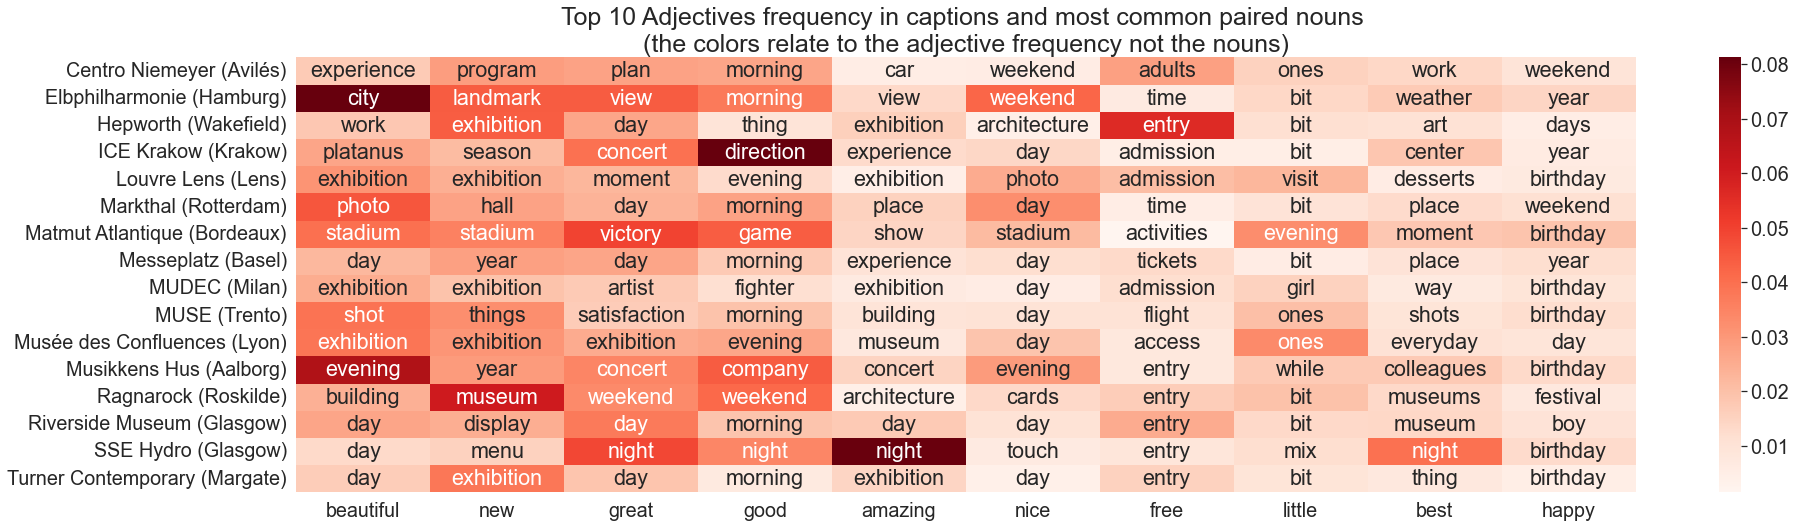

In [87]:
reset_layout()
sns.heatmap(adj_matrix_adj, cmap="Reds", annot=frequent_adjnouns, fmt='') # fmt: formatting, default is numeric format
plt.title("Top 10 Adjectives frequency in captions and most common paired nouns \n(the colors relate to the adjective frequency not the nouns)", fontsize=25)

**Observations**:
- 'free' about matches up with whether the museum has an entry fee (free 'evening'/'day) or not ('admission'/'entry'). One outlier is Centor Niemeyer which to my knowledge has an entry fee.
- 'beautiful' rarely (only for Ragnarock, Matmut) directly relates to the building, rather to a wider context(day/evening/city), shot in general (shot) or the programme (experience/exhibition)
 Top adjectives focus *not* on the programme for: Elphi, Markthal, Messeplatz, MUSE,


For the verbs I didn't augment with the paired nouns here since it's not very informative

  0%|          | 0/16 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Top 10 verbs frequency in captions')

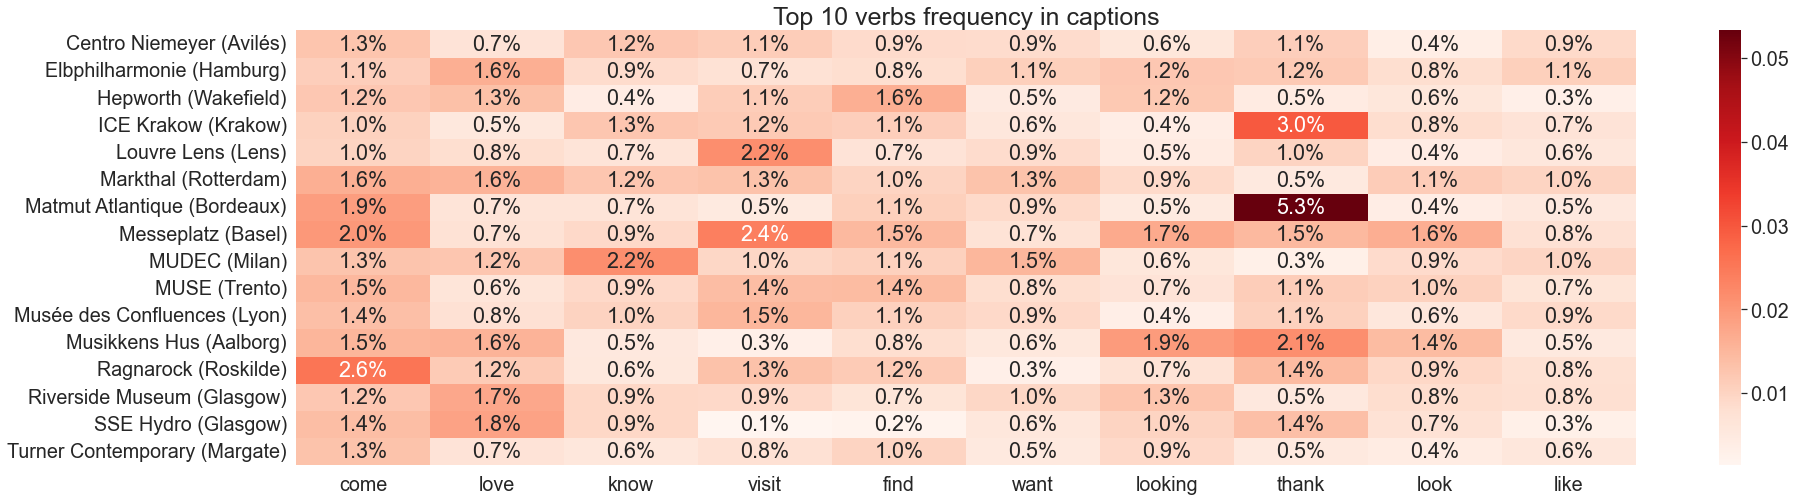

In [88]:
target_pos = "VERB"
verb_matrix = get_top_count_matrix(df_pos, projects, target_pos=target_pos, top_n=10)
sns.heatmap(verb_matrix, cmap="Reds", annot=verb_matrix, fmt=".1%")
plt.title("Top 10 verbs frequency in captions",fontsize=25)

**Observations**
Looks like shape 1 buildings seem to have high correlation (need to double check in detail) -> maybe calculate average correlation within each shape group and compare it to global average
-> can do NMF with projects as one big document each? and then extract similar documents (=projects?)
 -> but use all adjectives not just top 20

## Giving some context to the verbs+adjectives (pair with most frequent nount)
## adjectives

### Analysis of all adjectives using PCA

In [89]:
adj_matrix_all = get_top_count_matrix(df_pos, projects, target_pos="ADJ", top_n=None)

  0%|          | 0/16 [00:00<?, ?it/s]

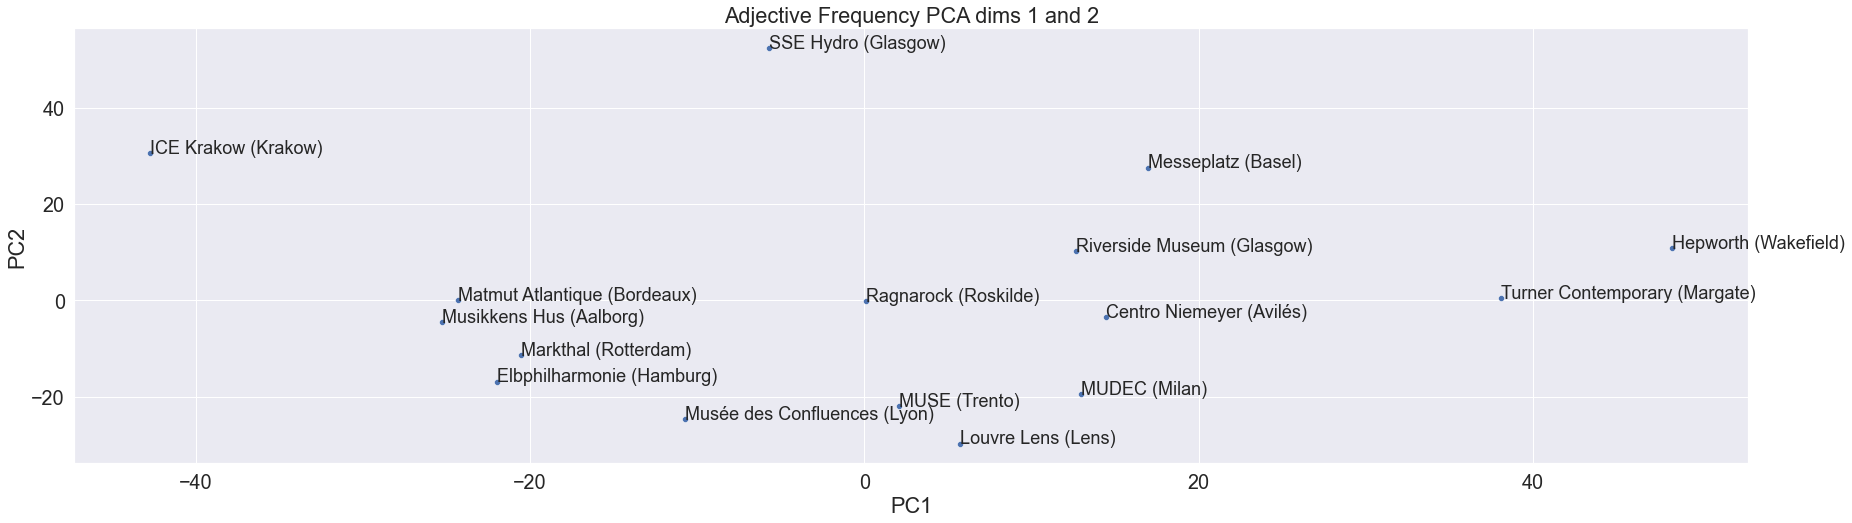

In [90]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

adj_matrix_all_t = adj_matrix_all.T

# Create a StandardScaler object
scaler = StandardScaler()

# Normalize the data
normalized_data = scaler.fit_transform(adj_matrix_all_t).T

# Create a PCA object
pca = PCA(n_components=2) # according to scree plot

# Fit the PCA object to the normalized data
pca.fit(normalized_data)

# Get the explained variance ratio of each component
explained_var_ratio = pca.explained_variance_ratio_

# Get the transformed data (project scores in the PCA space)
transformed_data = pca.transform(normalized_data)

sns.scatterplot(x=transformed_data[:, 0], y=transformed_data[:, 1])
for i, label in enumerate(projects):
    plt.text(x=transformed_data[i, 0], y=transformed_data[i, 1], s=label, fontsize=18)

# Set the title and axes labels
plt.title('Adjective Frequency PCA dims 1 and 2')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Show the plot
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

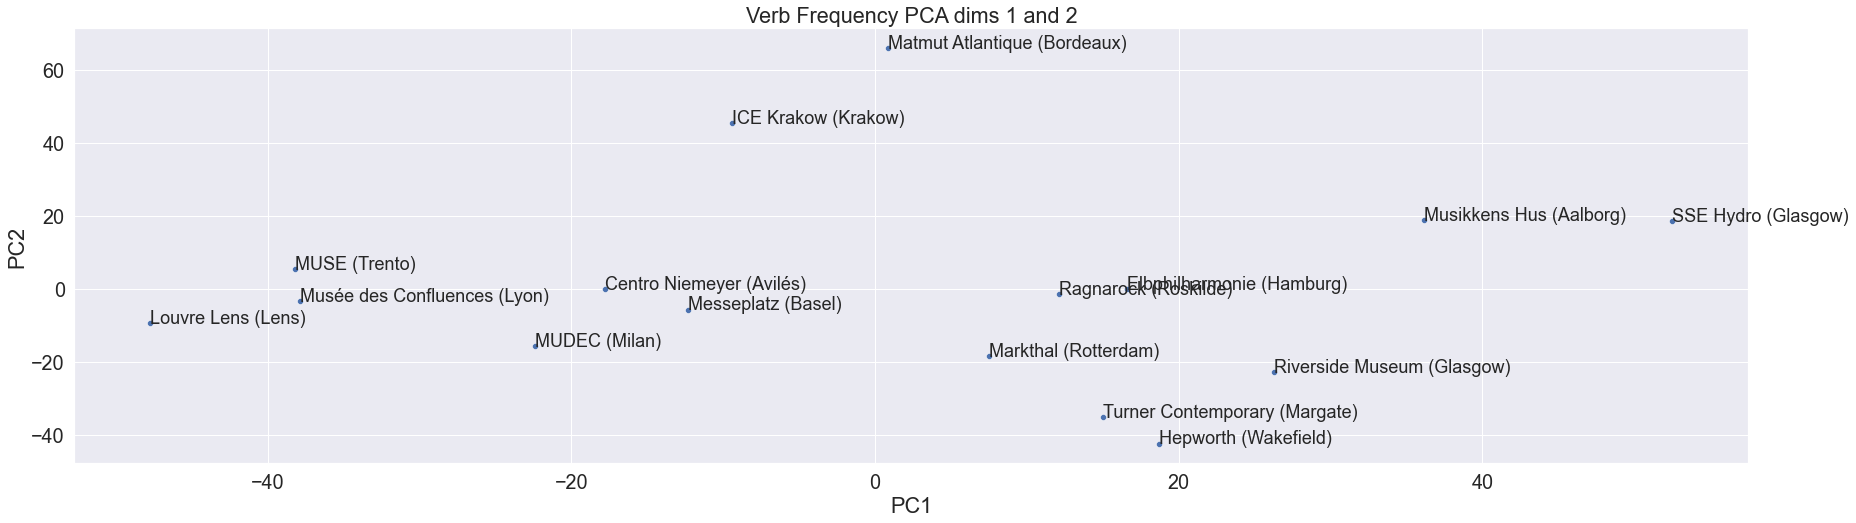

In [91]:
verb_matrix_all = get_top_count_matrix(df_pos, projects, target_pos="VERB", top_n=None)
verb_matrix_all_t = verb_matrix_all.T

# Create a StandardScaler object
scaler = StandardScaler()

# Normalize the data
normalized_data = scaler.fit_transform(verb_matrix_all_t).T

# Create a PCA object
pca = PCA(n_components=2) # according to scree plot

# Fit the PCA object to the normalized data
pca.fit(normalized_data)

# Get the explained variance ratio of each component
explained_var_ratio = pca.explained_variance_ratio_

# Get the transformed data (project scores in the PCA space)
transformed_data = pca.transform(normalized_data)

sns.scatterplot(x=transformed_data[:, 0], y=transformed_data[:, 1])
for i, label in enumerate(projects):
    plt.text(x=transformed_data[i, 0], y=transformed_data[i, 1], s=label, fontsize=18)

# Set the title and axes labels
plt.title('Verb Frequency PCA dims 1 and 2')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Show the plot
plt.show()

**Result** The clustering of adjective frequency aligns with post frequency curve shapes, bt only for adjectives and not for verbs...?

## Correlation with the city: Which city hashtag has the highest occurrence in project datasets?

In [92]:
# taken from the list of hashtags sorted by occurence
city_hashtag_lookup = {
    "Centro Niemeyer (Avilés)": ["#aviles", "#avilés"],
    "Elbphilharmonie (Hamburg)": ["#hamburg"],
    "Hepworth (Wakefield)": ["#wakefield"],
    "ICE Krakow (Krakow)": ["#krakow"],
    "Louvre Lens (Lens)": ["#lens"],
    "Markthal (Rotterdam)": ["#rotterdam"],
    "Matmut Atlantique (Bordeaux)": ["#bordeaux"],
    "Messeplatz (Basel)": ["#basel"],
    "MUDEC (Milan)": ["#milano", "#milan"],
    "MUSE (Trento)": ["#trento"],
    "Musée des Confluences (Lyon)": ["#lyon"],
    "Musikkens Hus (Aalborg)": ["#aalborg"],
    "Ragnarock (Roskilde)": ["#roskilde"],
    "Riverside Museum (Glasgow)": ["#glasgow"],
    "SSE Hydro (Glasgow)":  ["#glasgow"],
    "Turner Contemporary (Margate)": ["#margate"]
}

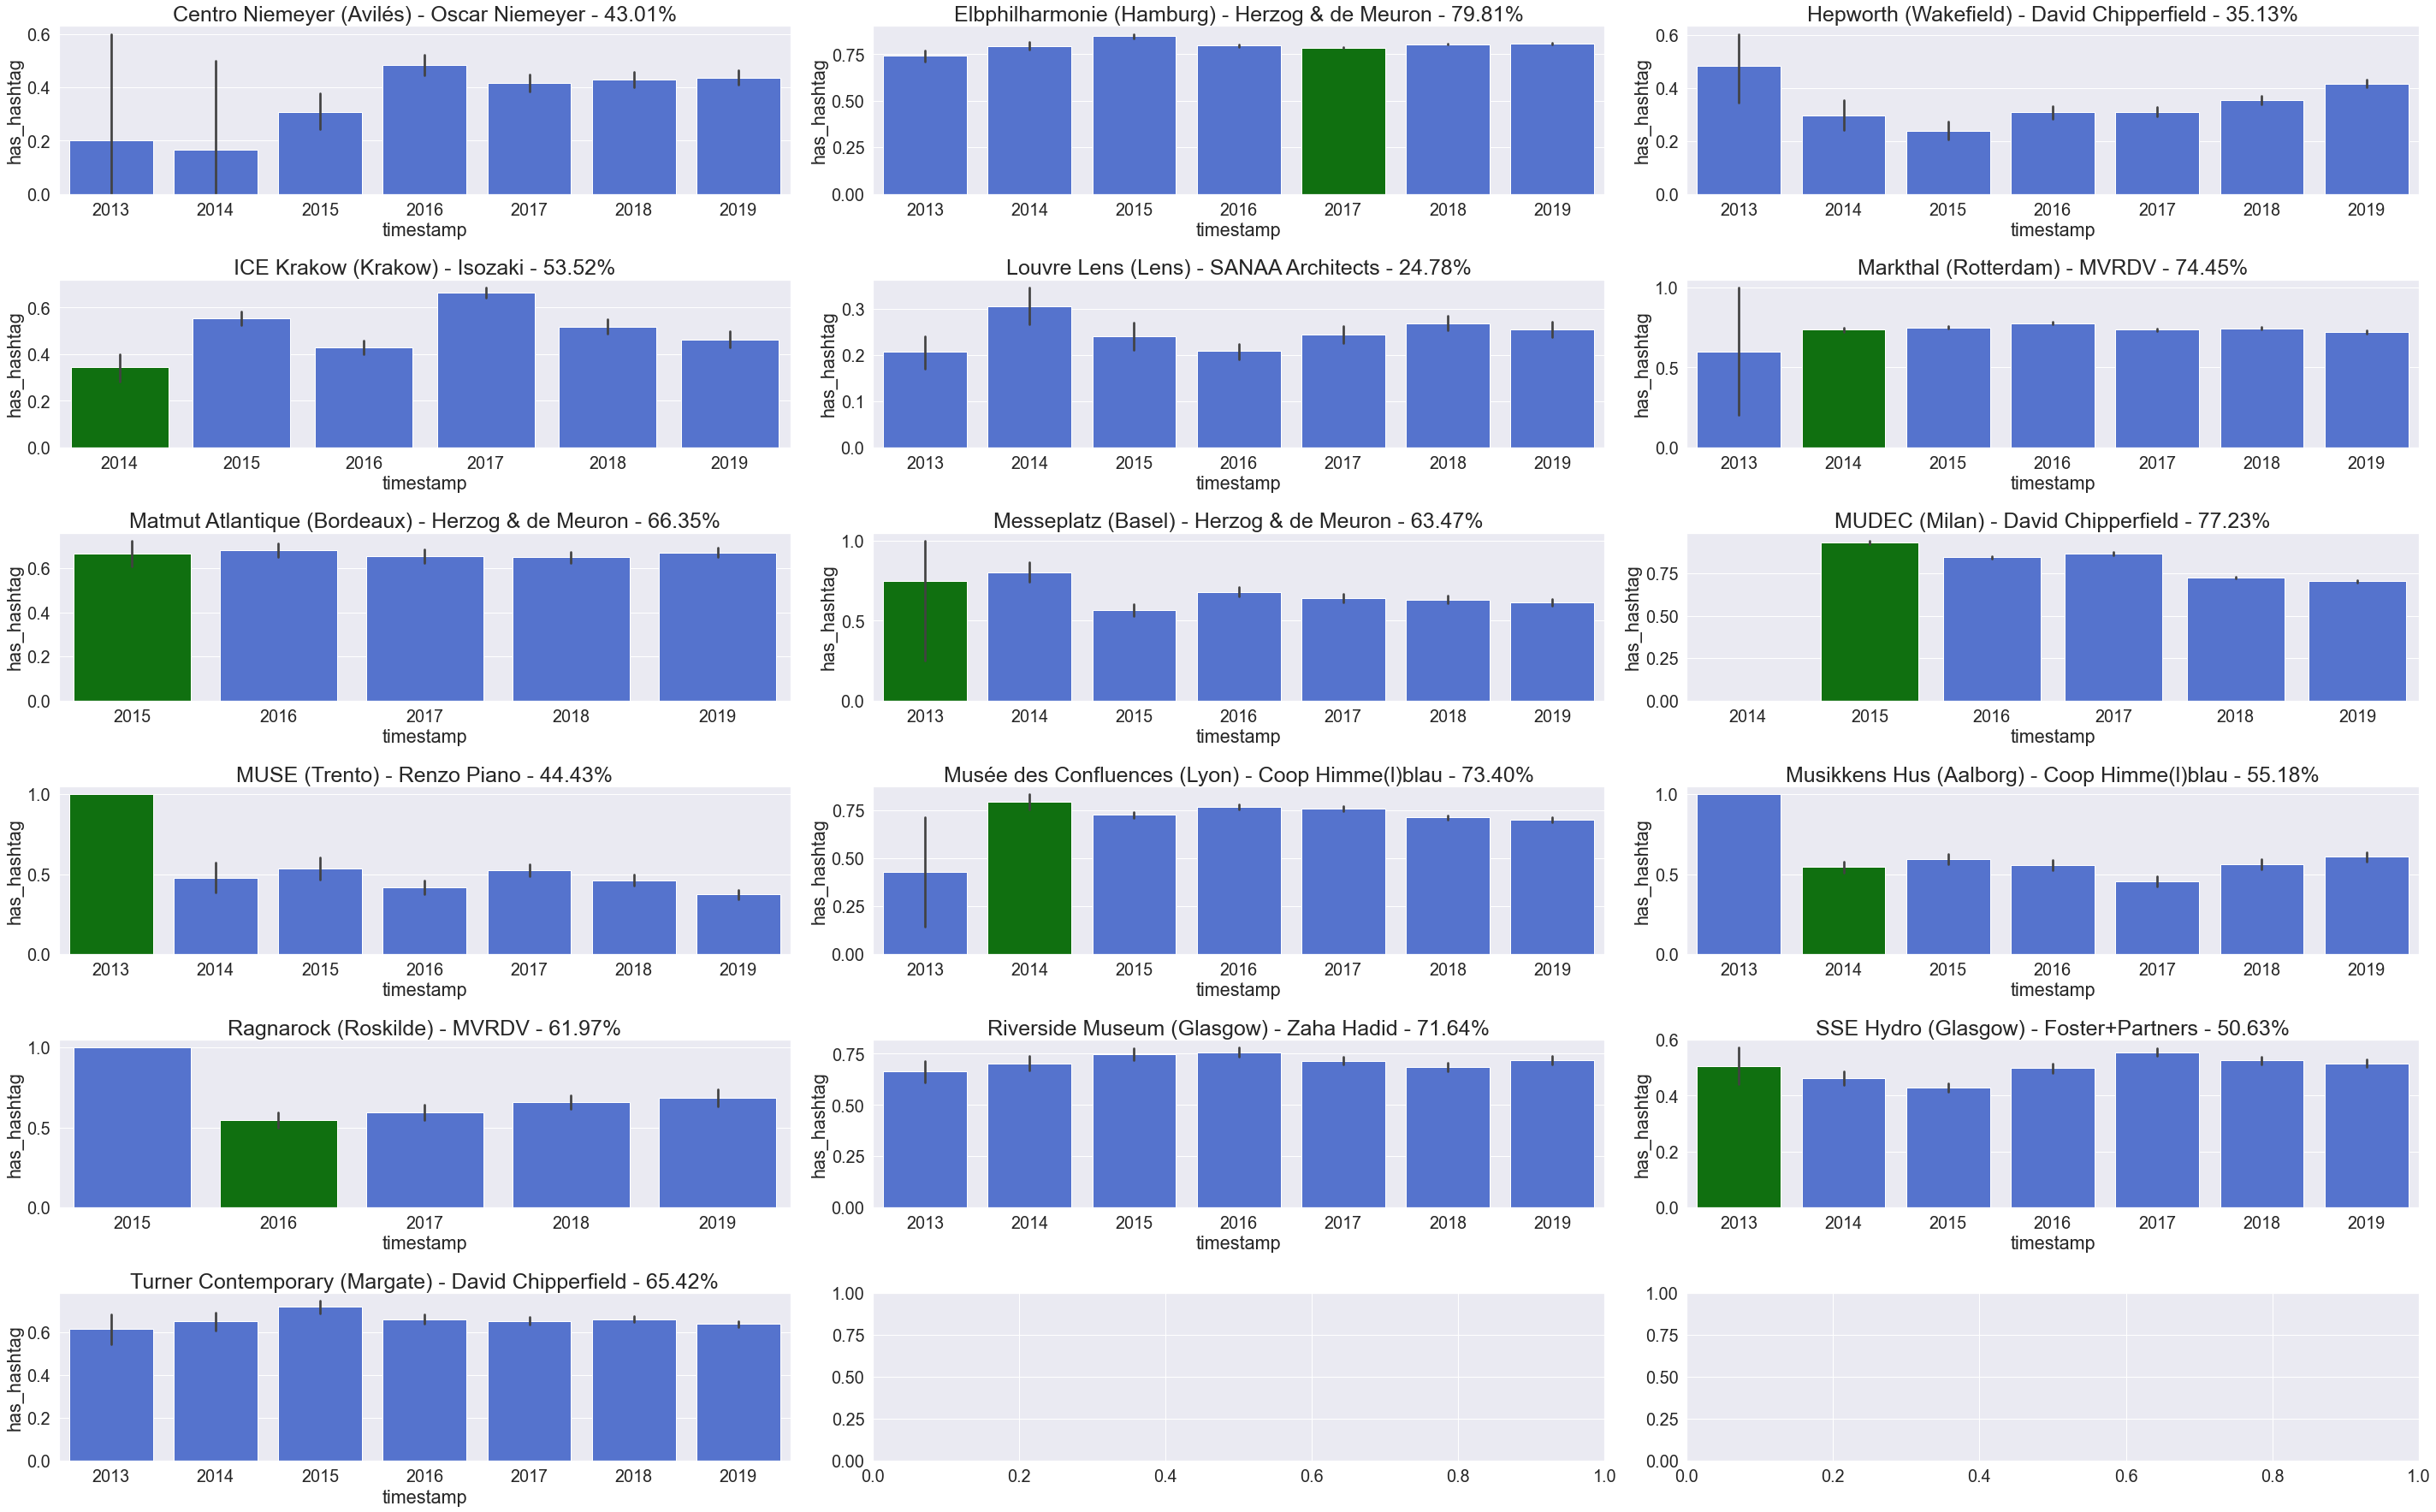

In [93]:
n_cols = 3
fig, axs = plt.subplots(6, n_cols, figsize=[40, 25])
for i, project in enumerate(data):
    res = data[project]
    df = res["df"]
    opening_year = pd.to_datetime(res["opening"]).year

    # create new dataframe whether the hashtag is present or not
    architect_hashtags = city_hashtag_lookup[project]
    has_hashtag = get_hashtag_presence(df["hashtags"], architect_hashtags)
    tmp = has_hashtag.rename("has_hashtag").to_frame()
    tmp["no_hashtag"] = ~tmp["has_hashtag"]
    tmp["total"] = 1

    # add result to df
    df["has_architect_hashtag"] = list(has_hashtag.astype(int))

    # limting the observation range to 2013+ since sample size is very small before that
    tmp = tmp[tmp.index.year >= 2013]

    # group by year and calculate realtive frequency of whether the hashtag is present
    freq_group = tmp.groupby(tmp.index.year)[["has_hashtag", "no_hashtag", "total"]].sum()
    freq_group["frequency"] = freq_group["has_hashtag"] / freq_group["total"]
    # freq_group.index = [str(x) for x in freq_group.index]
    total = freq_group["has_hashtag"].sum() / freq_group["total"].sum()
    # pl.stacked_barchart(freq_group[["has_hashtag", "no_hashtag"]])

    # plot hashtag frequency over time
    ax = axs[int(i / n_cols), i % n_cols]
    palette = {year: "royalblue" for year in np.unique(tmp.index.year)}
    palette[opening_year] = "green"
    sns.barplot(x=tmp.index.year, y=tmp["has_hashtag"], palette=palette, ax=ax)
    ax.set_title("{} - {} - {:.2%}".format(project, res["architect"], total), fontsize=25)
    # ax.axvline(x=2015, color='green',linewidth=3) # label='Opening: {}'.format(res["opening"])

    # collect hashtag frequency in table for all projects
    collector.append({"project": project, "architect": res["architect"], "hashtag freq": total})

plt.tight_layout()